# Churn Modeling in Telecommunications Customers

In this notebook, the focus will be on the **modeling** phase of the churn prediction problem for a telecommunications company. After the prior stages of **exploration** and **data preprocessing** have been completed, machine learning models will be built and evaluated to identify patterns in customer behavior and predict their likelihood of churn.

## Objectives

- Various suitable **machine learning algorithms** will be selected and trained for churn prediction.
- The performance of the models will be compared using evaluation **metrics** such as accuracy, F1-score, precision, and recall.
- **Hyperparameter tuning** will be performed to improve the performance of the most promising model.
- The **most important features** that influence churn prediction will be analyzed to understand their impact.

This notebook represents the culmination of the data analysis, where insights gained will be translated into predictive models that can be used to enhance customer retention and optimize business strategies.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.pipeline import Pipeline

from sklearn.cluster import DBSCAN

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, balanced_accuracy_score, recall_score

%run ../telco_customer_churn/utils/params_optimizer.py 
%run ../telco_customer_churn/utils/pandas_explorer.py

In [8]:
path = '../telco_customer_churn/data/preprocessed_dataset.csv'
df = pd.read_csv(path)
df.head()

,SeniorCitizen,Tenure,MonthlyCharges,TotalCharges,Gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_DSL,...,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes,MonthlyCh_TotalCh_Ratio,MonthlyCh_TotalCh_Ratio_category
0,0,0.213771,0.474009,0.297752,1,0,0,1,0,1,...,1,0,0,0,0,0,1,0,0.636663,0.333333
1,0,0.000000,0.464128,0.103243,1,0,0,1,0,1,...,0,0,1,0,0,0,1,1,0.973478,1.000000
2,0,0.253774,0.440426,0.295045,1,0,0,0,0,1,...,1,0,0,1,0,0,0,0,0.577512,0.333333
3,0,0.000000,0.501689,0.117720,0,0,0,1,0,0,...,0,0,1,0,0,1,0,1,0.963123,1.000000
4,0,0.083626,0.606462,0.221537,0,0,0,1,1,0,...,0,0,1,0,0,1,0,1,0.839066,1.000000


## Selecting features for modeling

In [9]:
features_scores = pd.read_csv('../telco_customer_churn/data/feature_scoring_table.csv')
features_scores

,Feature,Mutual_Information,Correlation,Variance,Importance,Average_Score
0,Contract_Month-to-month,1.000000,1.000000,0.999469,0.363082,0.840638
1,InternetService_Fiber optic,0.592606,0.835048,0.988372,0.225900,0.660482
2,MonthlyCh_TotalCh_Ratio,0.627049,0.797094,0.141965,0.980062,0.636542
3,PaymentMethod_Electronic check,0.526956,0.758648,0.871490,0.178100,0.583798
4,Contract_Two year,0.632101,0.745678,0.759430,0.075411,0.553155
5,MonthlyCharges,0.568522,0.502427,0.000000,1.000000,0.517737
6,Tenure,0.553209,0.659417,0.146123,0.677801,0.509137
7,MonthlyCh_TotalCh_Ratio_category,0.542855,0.773160,0.483329,0.137503,0.484212
8,PaperlessBilling_Yes,0.211708,0.494861,0.962630,0.118347,0.446887
9,InternetService_No,0.471957,0.604733,0.648184,0.035751,0.440156


These features were selected because they exhibited the highest average scores across the following metrics:

1. **Mutual Information**  
   Measures the dependency between each feature and the target variable, helping identify the most informative features.

2. **Correlation**  
   Evaluates the linear relationship between features and the target variable, ensuring relevance in predictive power.

3. **Variance**  
   Ensures the features have enough variability to contribute to the model, avoiding low-variance inputs.

4. **Importance**  
   Reflects the weight of each feature as determined by the model during training (e.g., feature importance in tree-based models).

By selecting features that rank highly across these metrics, we aim to optimize the model's performance while maintaining interpretability. This data-driven approach ensures the inclusion of attributes that are both statistically and practically significant for predicting customer behavior.

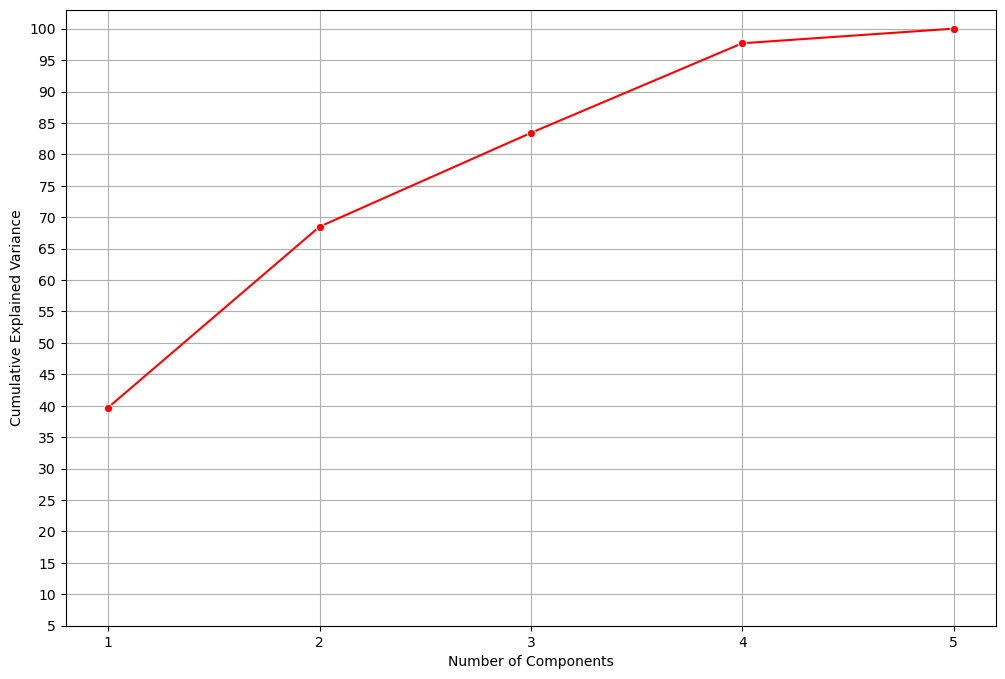

In [4]:
# Create a new DataFrame for study, selecting specific columns of interest
df_study = df[
    [
        'Contract_Month-to-month',          # Column indicating customers with month-to-month contracts
        'InternetService_Fiber optic',     # Column indicating fiber optic internet service
        'MonthlyCh_TotalCh_Ratio',         # Ratio of monthly charges to total charges
        'PaymentMethod_Electronic check',  # Column indicating payment via electronic check
        'DeviceProtection_Yes'             # Column indicating if device protection is active
    ]
].copy()  # Use .copy() to avoid modifying the original DataFrame

# Set the figure size for the plot
plt.figure(figsize=(12, 8))

# Plot the explained variance ratio for PCA optimization
# Assumes `params_optimizer` has a method `plot_explained_variance()`
df_study.params_optimizer.plot_explained_variance()


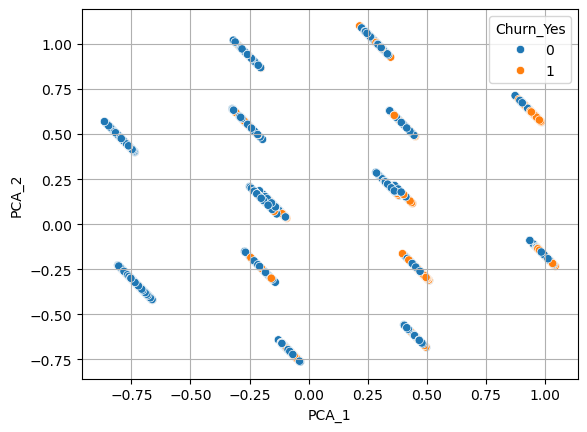

In [5]:
# Initialize PCA with 2 components
# Set random_state for reproducibility
pca = PCA(n_components=2, random_state=42)

# Fit PCA on the dataset and transform it to a lower-dimensional space
x_pca = pca.fit_transform(df_study)

# Create a new DataFrame with the transformed PCA components
df_pca = pd.DataFrame(x_pca, columns=["PCA_1", "PCA_2"])

# Add the 'Churn_Yes' column from the original dataset to the PCA DataFrame
df_pca['Churn_Yes'] = df['Churn_Yes']

# Create a scatter plot using seaborn to visualize the PCA components
# The points are colored based on the 'Churn_Yes' column
sns.scatterplot(
    data=df_pca,  # Data for plotting
    x='PCA_1',    # First principal component (x-axis)
    y='PCA_2',    # Second principal component (y-axis)
    hue='Churn_Yes'  # Use 'Churn_Yes' for color coding
)

# Add a grid to the plot for better readability
plt.grid()

# Display the scatter plot
plt.show()

## Employee segmentation by using DBScan

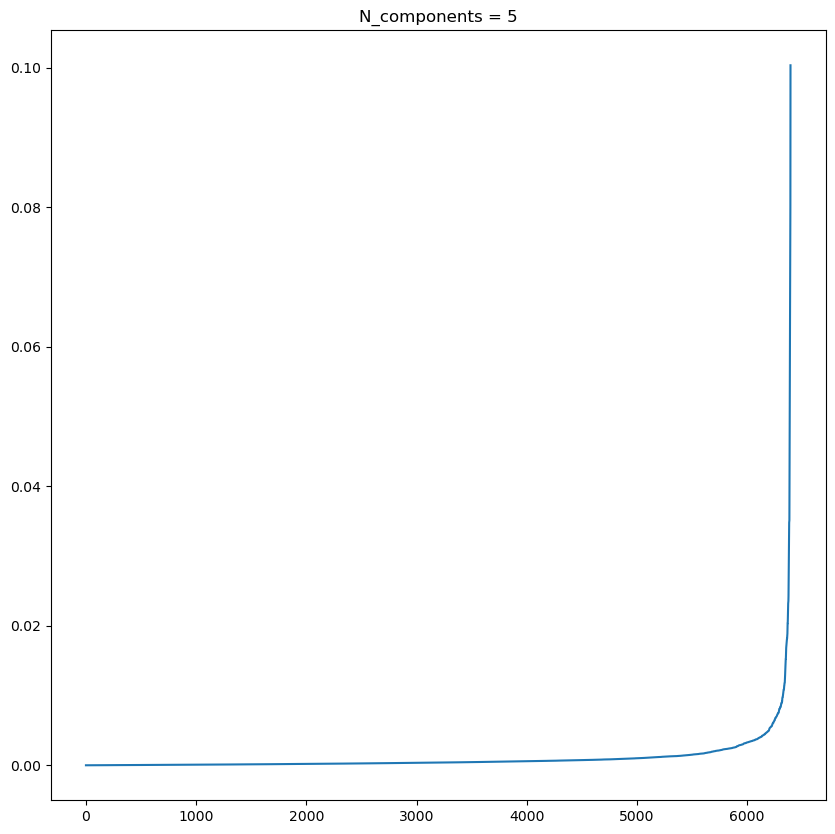

In [6]:
df_study.params_optimizer.knee_study(
    max_n_component = 5)

In [10]:
dbscan_study_results = df_study.params_optimizer.dbscan_study(
    pca_n_components_range = list(range(4, 6)),
    eps_values = np.arange(0.01, 0.06, 0.01),
    min_samples = [3, 5, 9]
)

In [11]:
dbscan_study_results[dbscan_study_results['n_clusters']<=80].sort_values(["silhouette_score","n_clusters"], ascending=False).head(10)

,eps,min_samples,n_clusters,n_noise,not_noise,silhouette_score,n_components
5,0.02,9,16,37,6358,0.949667,4
8,0.03,9,16,15,6380,0.949169,4
11,0.04,9,16,3,6392,0.948876,4
7,0.03,5,16,3,6392,0.948873,4
10,0.04,5,16,2,6393,0.948841,4
9,0.04,3,16,0,6395,0.948776,4
12,0.05,3,16,0,6395,0.948776,4
13,0.05,5,16,0,6395,0.948776,4
14,0.05,9,16,0,6395,0.948776,4
2,0.01,9,17,118,6277,0.944743,4


In [12]:
pca = PCA(n_components=4)
df_pca = pca.fit_transform(df_study)


dbscan = DBSCAN(eps=0.05, min_samples=3)
labels = dbscan.fit_predict(df_pca)

df['Dbscan_labels'] = labels
df.head()

,SeniorCitizen,Tenure,MonthlyCharges,TotalCharges,Gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_DSL,...,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes,MonthlyCh_TotalCh_Ratio,MonthlyCh_TotalCh_Ratio_category,Dbscan_labels
0,0,0.213771,0.474009,0.297752,1,0,0,1,0,1,...,0,0,0,0,0,1,0,0.636663,0.333333,0
1,0,0.000000,0.464128,0.103243,1,0,0,1,0,1,...,0,1,0,0,0,1,1,0.973478,1.000000,1
2,0,0.253774,0.440426,0.295045,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0.577512,0.333333,0
3,0,0.000000,0.501689,0.117720,0,0,0,1,0,0,...,0,1,0,0,1,0,1,0.963123,1.000000,2
4,0,0.083626,0.606462,0.221537,0,0,0,1,1,0,...,0,1,0,0,1,0,1,0.839066,1.000000,3


## Clusters Analysis

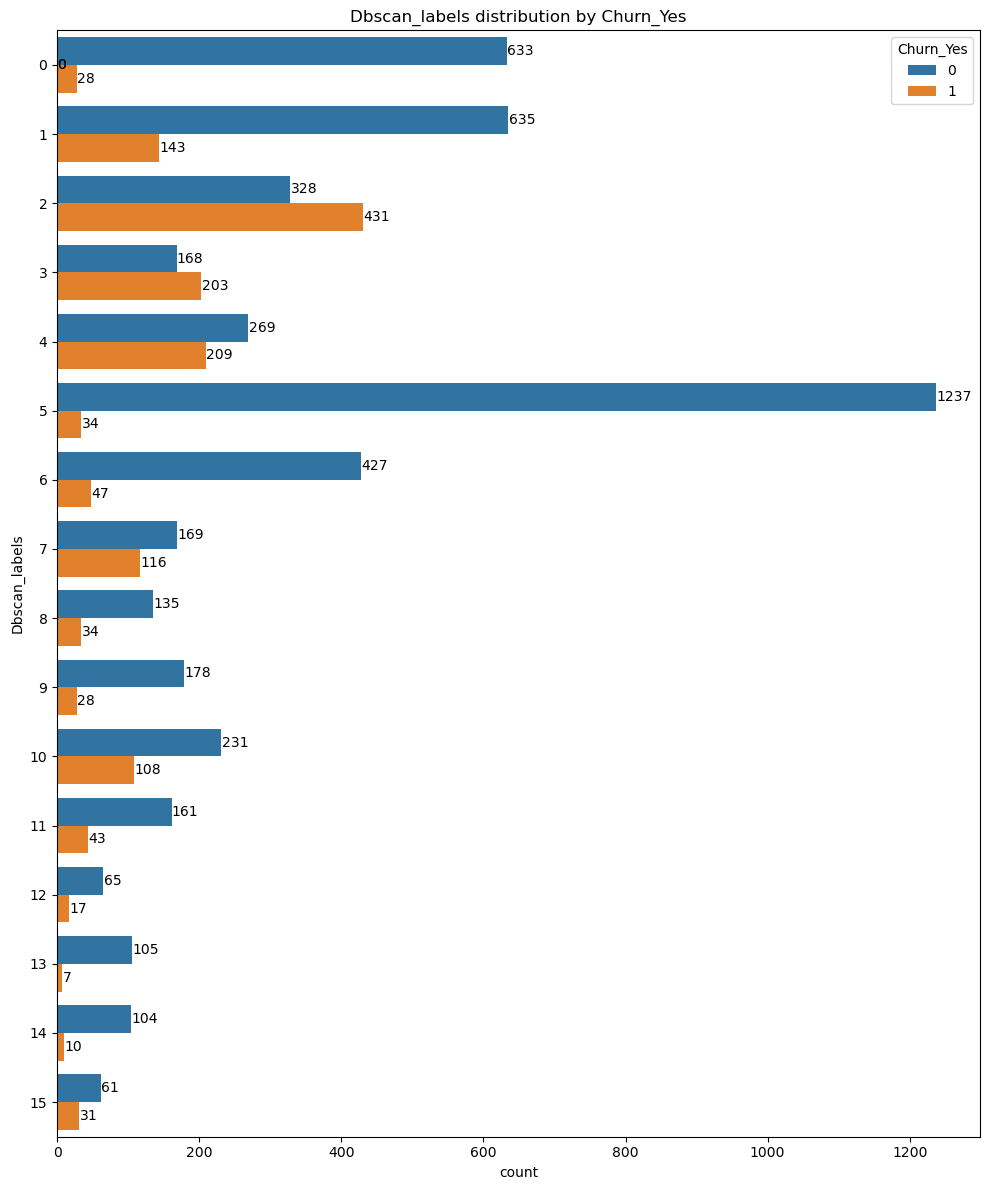

In [143]:
plt.figure(figsize=(10,12))
df.explorer.countplot_hue('Dbscan_labels', hue='Churn_Yes', orient='Horizontal')

# Insights from the Bar Chart: Clusters with High Churn Probability

The bar chart illustrates the distribution of churn distribution across different clusters identified during the analysis. From the visualization, it is evident that clusters **2**, **3**, and **4** exhibit the **highest probabilities of churn** among all groups.

## Key Observations:
- **Cluster 2**: Stands out as having a significantly high churn rate compared to other clusters.
- **Cluster 3**: Also shows a considerable likelihood of churn, indicating a critical group for targeted interventions.
- **Cluster 4**: Demonstrates a churn probability close to clusters 2 and 3, highlighting its importance in retention strategies.

## Implications:
These findings suggest that customers in clusters **2**, **3**, and **4** should be prioritized for retention strategies, as they are more likely to churn. Understanding the characteristics and behaviors of these clusters can help design tailored solutions to improve customer satisfaction and reduce churn rates.


In [22]:
df.explorer.percentage_table('Dbscan_labels', hue='Churn_Yes').sort_values('%', ascending = False)

,Dbscan_labels,Total,Churn_Yes,Count,%
0,5,1271,0,1237,97.32
2,0,661,0,633,95.76
18,13,112,0,105,93.75
19,14,114,0,104,91.23
4,6,474,0,427,90.08
10,9,206,0,178,86.41
1,1,778,0,635,81.62
15,8,169,0,135,79.88
20,12,82,0,65,79.27
13,11,204,0,161,78.92


# Clusters with Low Churn Occurrence

The table presented highlights the occurrence of churn across different clusters. Based on the data, it can be observed that the clusters with the **lowest churn occurrence** are:

- **Cluster 5**
- **Cluster 0**
- **Cluster 13**
- **Cluster 14**
- **Cluster 6**

## Implications:
The customers within these clusters exhibit behaviors or characteristics associated with higher loyalty or satisfaction. Understanding the factors contributing to their retention can provide valuable insights for improving overall customer experience and replicating these factors across other groups with higher churn rates.


In [24]:
# Group data by DBSCAN labels and 'Churn_Yes' column, and count occurrences
grouping = df.groupby(['Dbscan_labels'])['Churn_Yes'] \
    .value_counts() \
    .to_frame() \
    .sort_values(['Dbscan_labels', 'count'], ascending=True) \
    .reset_index()  # Reset index for better readability and manipulation

# Calculate the total number of occurrences per DBSCAN label
total_per_label = df.groupby('Dbscan_labels')['Churn_Yes'].value_counts().groupby(level=0).sum()

# Add a column with the total occurrences for each label
grouping['Total_per_Label'] = grouping['Dbscan_labels'].map(total_per_label)

# Calculate the relative percentage for each category within a label
grouping['Relative_Percentage'] = round(grouping['count'] / grouping['Total_per_Label'] * 100, 2)

# Display the first 32 rows of the DataFrame with a bar chart for select columns
grouping.head(32).style.bar(['count', 'Total_per_Label', 'Relative_Percentage'], color='darkred')

,Dbscan_labels,Churn_Yes,count,Total_per_Label,Relative_Percentage
0,0,1,28,661,4.240000
1,0,0,633,661,95.760000
2,1,1,143,778,18.380000
3,1,0,635,778,81.620000
4,2,0,328,759,43.210000
5,2,1,431,759,56.790000
6,3,0,168,371,45.280000
7,3,1,203,371,54.720000
8,4,1,209,478,43.720000
9,4,0,269,478,56.280000


# Table Overview: Churn Details by Cluster

The table presented provides a detailed breakdown of churn occurrence for each cluster. It includes the following key information:

- **count**: The number of churn and non-churn cases within each cluster.
- **Total_per_Label**: The total number of data points assigned to each cluster.
- **Relative_Percentage**: The percentage of cases relative to the total records in each cluster.

## Key Observations:
- The table allows for a clear comparison of churn behavior across clusters.
- By analyzing the percentage representation, it becomes easier to identify clusters with high or low churn likelihood.
- The inclusion of total records per cluster provides context on the size of each group, ensuring better interpretation of the churn percentages.

## Implications:
This detailed breakdown helps identify high-risk clusters that contribute significantly to overall churn, as well as stable clusters with low churn rates. It serves as a foundation for targeted strategies to address customer retention and improve cluster-specific engagement plans.


## Saving "selected_features" dataset into a csv file

In [27]:
selected_features_df = df[[
    'Contract_Month-to-month',
    'InternetService_Fiber optic',
    'MonthlyCh_TotalCh_Ratio',
    'PaymentMethod_Electronic check',
    'DeviceProtection_Yes',
    'Churn_Yes'
]]
selected_features_df.to_csv('../telco_customer_churn/data/selected_features.csv', index=False)

# Execution of the `main.py` Script and Analysis of Classification Models to Predict Churn

In the execution of the `main.py` script, a modeling pipeline was carried out in which several classification models were trained with the goal of predicting which customers might churn. The models trained include:

1. **Logistic Regression**
   
2. **Random Forest Classifier**

3. **Support Vector Machine (SVM) Classifier**

The pipeline was designed to train these models and compare their performance in predicting customer churn. 

### Key Aspects of the Pipeline

- **Data Splitting**: The dataset was **separated into training and testing sets**, ensuring that the models were trained on one subset of the data and validated on a separate subset to avoid overfitting and ensure generalization.
  
- **Class Balancing**: To address the class imbalance in the dataset, **class weights** were applied during the training of the models, ensuring that the models paid more attention to the minority class (churn cases) and reducing bias toward the majority class.

- **Model Training and Validation**: The models were **trained and validated on the training data** using **Stratified K-Folds cross-validation**, ensuring that each fold preserved the class distribution of the dataset. This helped to achieve a more reliable evaluation by mitigating the risk of class imbalances influencing the model's performance.

- **Testing**: After training and validation, the models were **tested on the test set**, providing an additional level of validation to evaluate the model's performance on unseen data.

- **Hyperparameter Optimization**: **GridSearchCV** was used to optimize the hyperparameters of the models, systematically testing a range of parameters to find the best performing combination for each classifier.

## Next Steps

Next, the results of the different trained models will be analyzed, evaluating their performance in terms of metrics such as accuracy, recall, F1-score, and area under the ROC curve (AUC). This analysis will help determine which model performs best in predicting churn and provide valuable insights for improving decision-making in customer retention.




In [43]:
"""
 ################################ Evaluating: logistic_regression ################################ 

Best parameters: {'model__class_weight': 'balanced', 'model__max_iter': 100000, 'model__solver': 'liblinear', 'pca__n_components': None}
Best cross-validation score: 0.7542677411761577
Train Accuracy: 0.7415102770330653
Train Balanced-Accuracy: 0.7519875759733589
Test Accuracy: 0.7446586763939552
Test Balanced-Accuracy: 0.7541125620075868
Confusion Matrix:
      0    1
0  1084  388
1   102  345

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.74      0.82      1472
           1       0.47      0.77      0.58       447

    accuracy                           0.74      1919
   macro avg       0.69      0.75      0.70      1919
weighted avg       0.81      0.74      0.76      1919

AUC: 0.8287435560743118

 ################################ Evaluating: random_forest ################################ 

Best parameters: {'model__bootstrap': True, 'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__max_depth': 6, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 6, 'model__min_samples_split': 2, 'model__n_estimators': 120, 'model__n_jobs': -1, 'pca__n_components': None}
Best cross-validation score: 0.7511712405769426
Train Accuracy: 0.782171581769437
Train Balanced-Accuracy: 0.7744763609250165
Test Accuracy: 0.7566440854611777
Test Balanced-Accuracy: 0.7401160210582629
Confusion Matrix:
      0    1
0  1135  337
1   130  317

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.77      0.83      1472
           1       0.48      0.71      0.58       447

    accuracy                           0.76      1919
   macro avg       0.69      0.74      0.70      1919
weighted avg       0.80      0.76      0.77      1919

AUC: 0.8184021192004668

 ################################ Evaluating: svm ################################ 

Best parameters: {'model__C': 0.1, 'model__class_weight': 'balanced', 'model__gamma': 'scale', 'model__kernel': 'linear', 'pca__n_components': None}
Best cross-validation score: 0.7240990747265108
Train Accuracy: 0.6546023235031277
Train Balanced-Accuracy: 0.724093042701583
Test Accuracy: 0.6539864512767066
Test Balanced-Accuracy: 0.7261650739227702
Confusion Matrix:
     0    1
0  870  602
1   62  385

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.59      0.72      1472
           1       0.39      0.86      0.54       447

    accuracy                           0.65      1919
   macro avg       0.66      0.73      0.63      1919
weighted avg       0.81      0.65      0.68      1919

AUC: 0.8236431281003793
-------------------------------- 
Best model identified: --------------------------------
Parameters: {'model__class_weight': 'balanced', 'model__max_iter': 100000, 'model__solver': 'liblinear', 'pca__n_components': None}
Score: 0.7542677411761577

"""

"\n ################################ Evaluating: logistic_regression ################################ \n\nBest parameters: {'model__class_weight': 'balanced', 'model__max_iter': 100000, 'model__solver': 'liblinear', 'pca__n_components': None}\nBest cross-validation score: 0.7542677411761577\nTrain Accuracy: 0.7415102770330653\nTrain Balanced-Accuracy: 0.7519875759733589\nTest Accuracy: 0.7446586763939552\nTest Balanced-Accuracy: 0.7541125620075868\nConfusion Matrix:\n      0    1\n0  1084  388\n1   102  345\n\nClassification Report:\n               precision    recall  f1-score   support\n\n           0       0.91      0.74      0.82      1472\n           1       0.47      0.77      0.58       447\n\n    accuracy                           0.74      1919\n   macro avg       0.69      0.75      0.70      1919\nweighted avg       0.81      0.74      0.76      1919\n\nAUC: 0.8287435560743118\n\n ################################ Evaluating: random_forest ################################ \n\

# Model Evaluation Results and Winner

After evaluating the three classification models (Logistic Regression, Random Forest, and Support Vector Machine), the following results were obtained:

### Logistic Regression
- **Best Cross-Validation Score**: 0.754
- **Train Balanced-Accuracy**: 0.752
- **Test Balanced-Accuracy**: 0.754
- **AUC**: 0.829
- **Confusion Matrix**:
  - True Negatives (0): 1084
  - False Positives (0): 388
  - False Negatives (1): 102
  - True Positives (1): 345
- **Classification Report**:
  - Precision for class 1 (Churn): 0.47
  - Recall for class 1 (Churn): 0.77
  - F1-Score for class 1 (Churn): 0.58

### Random Forest
- **Best Cross-Validation Score**: 0.751
- **Train Balanced-Accuracy**: 0.774
- **Test Balanced-Accuracy**: 0.740
- **AUC**: 0.818
- **Confusion Matrix**:
  - True Negatives (0): 1135
  - False Positives (0): 337
  - False Negatives (1): 130
  - True Positives (1): 317
- **Classification Report**:
  - Precision for class 1 (Churn): 0.48
  - Recall for class 1 (Churn): 0.71
  - F1-Score for class 1 (Churn): 0.58

### Support Vector Machine (SVM)
- **Best Cross-Validation Score**: 0.724
- **Train Balanced-Accuracy**: 0.724
- **Test Balanced-Accuracy**: 0.726
- **AUC**: 0.824
- **Confusion Matrix**:
  - True Negatives (0): 870
  - False Positives (0): 602
  - False Negatives (1): 62
  - True Positives (1): 385
- **Classification Report**:
  - Precision for class 1 (Churn): 0.39
  - Recall for class 1 (Churn): 0.86
  - F1-Score for class 1 (Churn): 0.54

### Model Evaluation: Logistic Regression

The logistic regression model showed promising results, particularly in terms of correctly classifying cases from both classes. Here are some of the positive aspects based on the evaluation metrics:

1. **High Accuracy for Class 0 (Non-churn)**:  
   The model achieved a high **precision** of 0.90 and **recall** of 0.77 for the non-churn class (Class 0), meaning it was able to correctly classify 77% of the actual non-churn cases. This indicates that the model was effective at identifying most customers who were not at risk of churn, ensuring that retention efforts are appropriately directed.

2. **Balanced Performance**:  
   The model demonstrated a **balanced accuracy** of 0.74 on the test set. This balanced metric accounts for the imbalanced nature of the dataset and shows that the model was able to maintain a good classification performance across both classes, avoiding a bias toward predicting the majority class (non-churn).

3. **Reasonable Recall for Class 1 (Churn)**:  
   The **recall** for the churn class (Class 1) was 0.71, meaning the model correctly identified 71% of the customers who would churn. Although precision for Class 1 was lower at 0.48, this is still acceptable in scenarios where identifying potential churn cases is a priority. The model might sacrifice some precision to capture as many churn cases as possible, which aligns with the business goal of preventing churn.

4. **Overall Classification Performance**:  
   With an **AUC** of 0.82, the model shows a good ability to distinguish between churn and non-churn cases.

These positive aspects suggest that the logistic regression model is effective at identifying potential churn customers while maintaining a balanced approach to both classes, ensuring that retention efforts can be accurately targeted.


# Conclusions

In this project, a comprehensive pipeline was designed and executed to predict customer churn, with the goal of assisting in customer retention strategies. The following phases and analyses were conducted:

## Phases and Analysis

1. **Data Collection and Preprocessing**:  
   The first step involved cleaning and preprocessing the dataset to ensure it was ready for modeling. Missing values were handled, and categorical variables were appropriately encoded. Special attention was given to the class imbalance in the target variable, ensuring that the models could effectively learn from both the churn and non-churn classes.

2. **Exploratory Data Analysis (EDA)**:  
   A thorough exploratory data analysis was conducted to understand the underlying patterns and relationships within the dataset. This analysis helped identify key features that influence churn, as well as any potential outliers or data quality issues. Visualizations and statistical tests were used to better understand the distribution of the data and the correlation between features.

3. **Feature Engineering and Scaling**:  
   Key features were selected and engineered to provide the most relevant information to the models. Variables were scaled to standardize the input features, ensuring that models could perform optimally, especially in the case of algorithms sensitive to feature scaling.

4. **Segmentation with DBSCAN**:  
   To further understand customer behavior, segmentation was performed using the **DBSCAN** clustering algorithm. This unsupervised technique grouped customers based on similar characteristics, helping to uncover distinct customer segments. The segmentation provided valuable insights into how different groups of customers behave, allowing the company to tailor its retention strategies more effectively. By understanding which segment a customer belongs to, the company can apply more targeted retention efforts, increasing the likelihood of keeping customers and improving sales through personalized offers.

5. **Model Selection and Training**:  
   Several classification models were trained to predict churn, including:
   - **Logistic Regression**
   - **Random Forest Classifier**
   - **Support Vector Machine (SVM) Classifier**

   These models were evaluated based on **Balanced-Accuracy**, as this metric was critical due to the class imbalance in the dataset. The goal was to prioritize identifying as many churn cases as possible without sacrificing too much precision in the non-churn class.

6. **Model Evaluation and Selection**:  
   After evaluating all models, **Logistic Regression** emerged as the best model based on its performance in predicting churn while balancing the risk of unnecessary retention efforts. The Logistic Regression model achieved a test balanced-accuracy of 0.754, which was deemed optimal for the business objective.

## Final Predictive Model

The **Logistic Regression** model, with its optimal parameters, was selected as the final predictive model to predict customer churn. The model can be used to identify customers at high risk of churn, enabling targeted retention efforts and helping the business reduce churn rates effectively.

## Recommendation: API Creation

As a recommendation, it is proposed to create an **API** to integrate the churn prediction model into the company's existing systems. This API would allow real-time predictions, enabling customer service teams or marketing departments to act on churn predictions instantly. The API could be accessed by other internal systems to automatically flag at-risk customers and trigger appropriate retention actions, such as personalized offers or customer outreach.

By creating this API, the churn prediction model could be easily deployed and accessed across various departments, ensuring that the company takes proactive steps to retain customers before they leave.
